In [1]:
import pymc
from glob import glob
import numpy as np

In [2]:
DG_min = np.log(1e-15) # kT, most favorable (negative) binding free energy possible; 1 fM
DG_max = +0 # kT, least favorable binding free energy possible

In [3]:
#this is just for the lognormal wrapper and inner filter effect and run_mcmc
from assaytools import pymcmodels
from assaytools import bindingmodels

In [4]:
from assaytools import parser
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
#This is our new competition assay model, which has competition as an option (note just for top fluroescence)
#if the values on the second line are included
def make_comp_model(Pstated, dPstated, Lstated, dLstated,
               Bstated = None, dBstated = None, DG_L_mean = None, DG_L_std = None, # specific for competition assay
               top_complex_fluorescence=None, top_ligand_fluorescence=None,
               DG_prior='uniform',
               concentration_priors='lognormal',
               quantum_yield_priors='lognormal',
               use_primary_inner_filter_correction=True,
               use_secondary_inner_filter_correction=True,
               assay_volume=100e-6, well_area=0.1586,
               epsilon_ex=None, depsilon_ex=None,
               epsilon_em=None, depsilon_em=None,
               ligand_ex_absorbance=None, ligand_em_absorbance=None,
               F_PL=None, dF_PL=None):

    # Compute path length.
    path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections

    # Compute number of samples.
    N = len(Lstated)
    
    # Check input.
    # TODO: Check fluorescence and absorbance measurements for correct dimensions.
    if (len(Pstated) != N):
        raise Exception('len(Pstated) [%d] must equal len(Lstated) [%d].' % (len(Pstated), len(Lstated)))
    if (len(dPstated) != N):
        raise Exception('len(dPstated) [%d] must equal len(Lstated) [%d].' % (len(dPstated), len(Lstated)))
    if (len(dLstated) != N):
        raise Exception('len(dLstated) [%d] must equal len(Lstated) [%d].' % (len(dLstated), len(Lstated)))

    # Note whether we have top or bottom fluorescence measurements.
    top_fluorescence = (top_complex_fluorescence is not None) or (top_ligand_fluorescence is not None) # True if any top fluorescence measurements provided

    # Create an empty dict to hold the model.
    model = dict()
    
    # Prior on binding free energies.
    if DG_prior == 'uniform':
        DeltaG_B = pymc.Uniform('DeltaG_B', lower=DG_min, upper=DG_max) # binding free energy (kT), uniform over huge range
    elif DG_prior == 'chembl':
        DeltaG_B = pymc.Normal('DeltaG_B', mu=0, tau=1./(12.5**2)) # binding free energy (kT), using a Gaussian prior inspured by ChEMBL
    else:
        raise Exception("DG_prior = '%s' unknown. Must be one of 'uniform' or 'chembl'." % DG_prior)
    model['DeltaG_B'] = DeltaG_B
    
    # Prior on known binding free energy.
    if DG_L_mean == None:
        DeltaG_L = pymc.Uniform('DeltaG_L', lower=DG_min, upper=DG_max) # binding free energy (kT), uniform over huge range
    else:
        DeltaG_L = pymc.Normal('DeltaG_L', mu=DG_L_mean, tau=DG_L_std) 
    model['DeltaG_L'] = DeltaG_L
        
    if concentration_priors != 'lognormal':
        raise Exception("concentration_priors = '%s' unknown. Must be one of ['lognormal']." % concentration_priors)
    model['log_Ptrue'], model['Ptrue'] = pymcmodels.LogNormalWrapper('Ptrue', mean=Pstated, stddev=dPstated, size=Pstated.shape) # protein concentration (M)
    model['log_Ltrue'], model['Ltrue'] = pymcmodels.LogNormalWrapper('Ltrue', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration (M)
    model['log_Btrue'], model['Btrue'] = pymcmodels.LogNormalWrapper('Btrue', mean=Bstated, stddev=dBstated, size=Bstated.shape) # ligand concentration (M)
    model['log_Ltrue_control'], model['Ltrue_control'] = pymcmodels.LogNormalWrapper('Ltrue_control', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration in ligand-only wells (M)

    # extinction coefficient
    model['epsilon_ex'] = 0.0
    if use_primary_inner_filter_correction:
        if epsilon_ex:
            model['log_epsilon_ex'], model['epsilon_ex'] =  pymcmodels.LogNormalWrapper('epsilon_ex', mean=epsilon_ex, stddev=depsilon_ex) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_ex'] = pymc.Uniform('epsilon_ex', lower=0.0, upper=1000e3, value=70000.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    model['epsilon_em'] = 0.0
    if use_secondary_inner_filter_correction:
        if epsilon_em:
            model['log_epsilon_em'], model['epsilon_em'] =  pymcmodels.LogNormalWrapper('epsilon_em', mean=epsilon_em, stddev=depsilon_em) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_em'] = pymc.Uniform('epsilon_em', lower=0.0, upper=1000e3, value=0.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    # Min and max observed fluorescence.
    Fmax = 0.0; Fmin = 1e6;
    if top_complex_fluorescence is not None:
        Fmax = max(Fmax, top_complex_fluorescence.max()); Fmin = min(Fmin, top_complex_fluorescence.min())
    if top_ligand_fluorescence is not None:
        Fmax = max(Fmax, top_ligand_fluorescence.max()); Fmin = min(Fmin, top_ligand_fluorescence.min())

    # Compute initial guesses for fluorescence quantum yield quantities.
    F_plate_guess = Fmin
    F_buffer_guess = Fmin / path_length
    F_L_guess = (Fmax - Fmin) / Lstated.max()
    F_P_guess = Fmin
    F_P_guess = Fmin / Pstated.min()
    F_PL_guess = (Fmax - Fmin) / min(Pstated.max(), Lstated.max())

    # Priors on fluorescence intensities of complexes (later divided by a factor of Pstated for scale).

    if quantum_yield_priors == 'lognormal':
        stddev = 1.0 # relative factor for stddev guess
        model['log_F_plate'], model['F_plate'] =  pymcmodels.LogNormalWrapper('F_plate', mean=F_plate_guess, stddev=stddev*F_plate_guess) # plate fluorescence
        model['log_F_buffer'], model['F_buffer'] =  pymcmodels.LogNormalWrapper('F_buffer', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        model['log_F_buffer_control'], model['F_buffer_control'] =  pymcmodels.LogNormalWrapper('F_buffer_control', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        if (F_PL is not None) and (dF_PL is not None):
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL, stddev=dF_PL)
        else:
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL_guess, stddev=stddev*F_PL_guess) # complex fluorescence
        model['log_F_P'], model['F_P'] =  pymcmodels.LogNormalWrapper('F_P', mean=F_P_guess, stddev=stddev*F_P_guess) # protein fluorescence
        model['log_F_L'], model['F_L'] =  pymcmodels.LogNormalWrapper('F_L', mean=F_L_guess, stddev=stddev*F_L_guess) # ligand fluorescence
    else:
        raise Exception("quantum_yield_priors = '%s' unknown. Must be one of ['lognormal', 'uniform']." % quantum_yield_priors)

    # Unknown experimental measurement error.
    if top_fluorescence:
        model['log_sigma_top'] = pymc.Uniform('log_sigma_top', lower=-10, upper=np.log(Fmax), value=np.log(5))
        model['sigma_top'] = pymc.Lambda('sigma_top', lambda log_sigma=model['log_sigma_top'] : np.exp(log_sigma) )
        model['precision_top'] = pymc.Lambda('precision_top', lambda log_sigma=model['log_sigma_top'] : np.exp(-2*log_sigma) )

    if top_fluorescence:
        model['log_sigma_abs'] = pymc.Uniform('log_sigma_abs', lower=-10, upper=0, value=np.log(0.01))
        model['sigma_abs'] = pymc.Lambda('sigma_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(log_sigma) )
        model['precision_abs'] = pymc.Lambda('precision_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(-2*log_sigma) )

    if top_complex_fluorescence is not None:
        @pymc.deterministic
        def top_complex_fluorescence_model(F_plate=model['F_plate'], F_buffer=model['F_buffer'],
                                           F_PL=model['F_PL'], F_P=model['F_P'], F_L=model['F_L'],
                                           Ptrue=model['Ptrue'], Ltrue=model['Ltrue'], Btrue=model['Btrue'], DeltaG_L=model['DeltaG_L'], DeltaG_B=model['DeltaG_B'],
                                           epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            [P_i, L_i, PL_i, B_i, PB_i] = bindingmodels.CompetitionBindingModel.equilibrium_concentrations(Ptrue[:], Ltrue[:], DeltaG_L, Btrue[:], DeltaG_B)
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_i, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*L_i) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_complex_fluorescence_model'] = top_complex_fluorescence_model
        model['log_top_complex_fluorescence'], model['top_complex_fluorescence'] = pymcmodels.LogNormalWrapper('top_complex_fluorescence',
            mean=model['top_complex_fluorescence_model'], stddev=model['sigma_top'],
            size=[N], observed=True, value=top_complex_fluorescence) # observed data
        
    if top_ligand_fluorescence is not None:
        @pymc.deterministic
        def top_ligand_fluorescence_model(F_plate=model['F_plate'], F_buffer_control=model['F_buffer_control'],
                                          F_L=model['F_L'],
                                          Ltrue_control=model['Ltrue_control'],
                                          epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, Ltrue_control, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*Ltrue_control) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_L*Ltrue_control + F_buffer_control*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_ligand_fluorescence_model'] = top_ligand_fluorescence_model
        model['log_top_ligand_fluorescence'], model['top_ligand_fluorescence'] = pymcmodels.LogNormalWrapper('top_ligand_fluorescence',
                                                       mean=model['top_ligand_fluorescence_model'], stddev=model['sigma_top'],
                                                       size=[N], observed=True, value=top_ligand_fluorescence) # observed data
        
    #Below this is competition model stuff!    
    
    # Compute number of samples.
    if Bstated is not None:
        N_B = len(Bstated)

        # Check input.
        # TODO: Check fluorescence and absorbance measurements for correct dimensions.
        if (len(Lstated) != N_B):
            raise Exception('len(Lstated) [%d] must equal len(Bstated) [%d].' % (len(Lstated), len(Bstated)))
        if (len(Pstated) != N_B):
            raise Exception('len(Pstated) [%d] must equal len(Bstated) [%d].' % (len(Pstated), len(Bstated)))
        if (len(dPstated) != N_B):
            raise Exception('len(dPstated) [%d] must equal len(Bstated) [%d].' % (len(dPstated), len(Bstated)))
        if (len(dBstated) != N_B):
            raise Exception('len(dBstated) [%d] must equal len(Bstated) [%d].' % (len(dBstated), len(Bstated)))

            
    if Bstated is not None:
        @pymc.deterministic
        def top_complex_fluorescence_model(F_plate=model['F_plate'], F_buffer=model['F_buffer'],
                                           F_PL=model['F_PL'], F_P=model['F_P'], F_L=model['F_L'],
                                           Ptrue=model['Ptrue'], Ltrue=model['Ltrue'], Btrue=model['Btrue'],
                                           DeltaG_L=model['DeltaG_L'], DeltaG_B=model['DeltaG_B'],
                                           epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            [P_i, L_i, PL_i, B_i, PB_i] = bindingmodels.CompetitionBindingModel.equilibrium_concentrations(Ptrue[:], Ltrue[:], DeltaG_L, Btrue[:], DeltaG_B)
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_i, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*L_i) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_complex_fluorescence_model'] = top_complex_fluorescence_model
        model['log_top_complex_fluorescence'], model['top_complex_fluorescence'] = pymcmodels.LogNormalWrapper('top_complex_fluorescence',
            mean=model['top_complex_fluorescence_model'], stddev=model['sigma_top'],
            size=[N], observed=True, value=top_complex_fluorescence) # observed data

        @pymc.deterministic
        def top_ligand_fluorescence_model(F_plate=model['F_plate'], F_buffer_control=model['F_buffer_control'],
                                          F_L=model['F_L'],
                                          Ltrue_control=model['Ltrue_control'],
                                          epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, Ltrue_control, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*Ltrue_control) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_L*Ltrue_control + F_buffer_control*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_ligand_fluorescence_model'] = top_ligand_fluorescence_model
        model['log_top_ligand_fluorescence'], model['top_ligand_fluorescence'] = pymcmodels.LogNormalWrapper('top_ligand_fluorescence',
                                                       mean=model['top_ligand_fluorescence_model'], stddev=model['sigma_top'],
                                                       size=[N], observed=True, value=top_ligand_fluorescence) # observed data
    # Promote this to a full-fledged PyMC model.
    pymc_model = pymc.Model(model)

    # Return the pymc model
    return pymc_model

In [6]:
inputs = {
    'xml_file_path' :  "./data/",
    'file_set'      :  {'Abl-IMA': glob("./data/Abl*16-22-45_plate*.xml")},
    'ligand_order'  :  ['Gefitinib','Gefitinib','Gefitinib','Gefitinib'],
    'competitive_ligand'  :  'Imatinib',
    'section'       :  '280_BottomRead',
    'Lstated'       :  np.array([20.0e-6,9.15e-6,4.18e-6,1.91e-6,0.875e-6,0.4e-6,0.183e-6,0.0837e-6,0.0383e-6,0.0175e-6,0.008e-6,0.0], np.float64), # ligand concentration, M
    'Bstated'       :  10.0e-6 * np.ones([12],np.float64), # competitive ligand concentration, M
    'Pstated'       :  0.5e-6 * np.ones([12],np.float64), # protein concentration, M
    'assay_volume'  :  100e-6, # assay volume, L
    'well_area'     :  0.3969, # well area, cm^2 for 4ti-0203 [http://4ti.co.uk/files/3113/4217/2464/4ti-0201.pdf],
    'DG_L_mean'     :  -12.5, #DeltaG of Gefitinib mean estimate (kT)
    'DG_L_std'      :  1      #DeltaG of Gefitinib standard deviation estimate (kT)
    }

In [7]:
dPstated = 0.35 * inputs['Pstated'] # protein concentration uncertainty
dLstated = 0.08 * inputs['Lstated'] # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)
dBstated = 0.08 * inputs['Bstated'] # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

In [8]:
[complex_fluorescence_comp, ligand_fluorescence_comp] = parser.get_data_using_inputs(inputs)  

Skipping analysis of rows:  []


In [9]:
name = 'Abl-IMA-Gefitinib-AB'

In [10]:
pymc_comp_model = make_comp_model(inputs['Pstated'], dPstated, inputs['Lstated'], dLstated,
    inputs['Bstated'], dBstated, inputs['DG_L_mean'], inputs['DG_L_std'],# specific for competition assay
    top_complex_fluorescence=complex_fluorescence_comp[name],
    top_ligand_fluorescence=ligand_fluorescence_comp[name],
    use_primary_inner_filter_correction=True,
    use_secondary_inner_filter_correction=True,
    assay_volume=inputs['assay_volume'], DG_prior='uniform')

In [11]:
comp_mcmc = pymc.MCMC(pymc_comp_model)

/Users/choderaj/miniconda/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


In [12]:
nburn = 500
niter = 50000
nthin = 20

In [13]:
from datetime import datetime

In [14]:
str(datetime.now())

'2019-03-25 22:39:53.001431'

In [15]:
comp_mcmc.sample(iter=(nburn+niter), burn=nburn, thin=nthin, progress_bar=False, tune_throughout=True)

AssertionError: 

In [ ]:
str(datetime.now())

In [ ]:
plt.plot(comp_mcmc.DeltaG_L.trace())
plt.plot(comp_mcmc.DeltaG_B.trace())

In [24]:
Abl_gefitinib = 2200e-9 # 2200 nM from DiscoverRx screen data 

AblGef_dG = np.log(Abl_gefitinib)

Abl_imatinib = 1.1e-9 # 1.1 nM from DiscoverRx screen data 

AblIma_dG = np.log(Abl_imatinib)

In [ ]:
plt.figure(figsize=(12,10))
plt.hist(comp_mcmc.DeltaG_L.trace(),normed=True,label='DelG_L(Gef) = %s' %comp_mcmc.DeltaG_L.trace().mean());
plt.axvline(x=AblGef_dG,color='b',linestyle='--',label='IUPHARM Gef')
plt.hist(comp_mcmc.DeltaG_B.trace(),normed=True,label='DelG_B(Ima) = %s' %comp_mcmc.DeltaG_B.trace().mean());
plt.axvline(x=AblIma_dG,color='orange',linestyle='--',label='IUPHARM Ima')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.legend(loc=0);

# Below we do the same thing but for the general binding model

In [16]:
def make_gen_model(Pstated, dPstated, Lstated, dLstated,
               Bstated = None, dBstated = None, DG_L_mean = None, DG_L_std = None, # specific for competition assay
               top_complex_fluorescence=None, top_ligand_fluorescence=None,
               DG_prior='uniform',
               concentration_priors='lognormal',
               quantum_yield_priors='lognormal',
               use_primary_inner_filter_correction=True,
               use_secondary_inner_filter_correction=True,
               assay_volume=100e-6, well_area=0.1586,
               epsilon_ex=None, depsilon_ex=None,
               epsilon_em=None, depsilon_em=None,
               ligand_ex_absorbance=None, ligand_em_absorbance=None,
               F_PL=None, dF_PL=None):

    assert (DG_L_std > 0)
    
    # Compute path length.
    assert (well_area > 0)
    path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections

    # Compute number of samples.
    N = len(Lstated)
    
    # Check input.
    # TODO: Check fluorescence and absorbance measurements for correct dimensions.
    if (len(Pstated) != N):
        raise Exception('len(Pstated) [%d] must equal len(Lstated) [%d].' % (len(Pstated), len(Lstated)))
    if (len(dPstated) != N):
        raise Exception('len(dPstated) [%d] must equal len(Lstated) [%d].' % (len(dPstated), len(Lstated)))
    if (len(dLstated) != N):
        raise Exception('len(dLstated) [%d] must equal len(Lstated) [%d].' % (len(dLstated), len(Lstated)))

    # Note whether we have top or bottom fluorescence measurements.
    top_fluorescence = (top_complex_fluorescence is not None) or (top_ligand_fluorescence is not None) # True if any top fluorescence measurements provided

    # Create an empty dict to hold the model.
    model = dict()
    
    # Prior on binding free energies.
    if DG_prior == 'uniform':
        DeltaG_B = pymc.Uniform('DeltaG_B', lower=DG_min, upper=DG_max) # binding free energy (kT), uniform over huge range
    elif DG_prior == 'chembl':
        DeltaG_B = pymc.Normal('DeltaG_B', mu=0, tau=1./(12.5**2)) # binding free energy (kT), using a Gaussian prior inspured by ChEMBL
    else:
        raise Exception("DG_prior = '%s' unknown. Must be one of 'uniform' or 'chembl'." % DG_prior)
    model['DeltaG_B'] = DeltaG_B
    
    # Prior on known binding free energy.
    if DG_L_mean == None:
        DeltaG_L = pymc.Uniform('DeltaG_L', lower=DG_min, upper=DG_max) # binding free energy (kT), uniform over huge range
    else:
        DeltaG_L = pymc.Normal('DeltaG_L', mu=DG_L_mean, tau=DG_L_std**(-2)) 
    model['DeltaG_L'] = DeltaG_L
        
    if concentration_priors != 'lognormal':
        raise Exception("concentration_priors = '%s' unknown. Must be one of ['lognormal']." % concentration_priors)
    model['log_Ptrue'], model['Ptrue'] = pymcmodels.LogNormalWrapper('Ptrue', mean=Pstated, stddev=dPstated, size=Pstated.shape) # protein concentration (M)
    model['log_Ltrue'], model['Ltrue'] = pymcmodels.LogNormalWrapper('Ltrue', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration (M)
    model['log_Btrue'], model['Btrue'] = pymcmodels.LogNormalWrapper('Btrue', mean=Bstated, stddev=dBstated, size=Bstated.shape) # ligand concentration (M)
    model['log_Ltrue_control'], model['Ltrue_control'] = pymcmodels.LogNormalWrapper('Ltrue_control', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration in ligand-only wells (M)

    # extinction coefficient
    model['epsilon_ex'] = 0.0
    if use_primary_inner_filter_correction:
        if epsilon_ex:
            model['log_epsilon_ex'], model['epsilon_ex'] =  pymcmodels.LogNormalWrapper('epsilon_ex', mean=epsilon_ex, stddev=depsilon_ex) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_ex'] = pymc.Uniform('epsilon_ex', lower=0.0, upper=1000e3, value=70000.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    model['epsilon_em'] = 0.0
    if use_secondary_inner_filter_correction:
        if epsilon_em:
            model['log_epsilon_em'], model['epsilon_em'] =  pymcmodels.LogNormalWrapper('epsilon_em', mean=epsilon_em, stddev=depsilon_em) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_em'] = pymc.Uniform('epsilon_em', lower=0.0, upper=1000e3, value=0.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    # Min and max observed fluorescence.
    Fmax = 0.0; Fmin = 1e6;
    if top_complex_fluorescence is not None:
        Fmax = max(Fmax, top_complex_fluorescence.max()); Fmin = min(Fmin, top_complex_fluorescence.min())
    if top_ligand_fluorescence is not None:
        Fmax = max(Fmax, top_ligand_fluorescence.max()); Fmin = min(Fmin, top_ligand_fluorescence.min())

    # Compute initial guesses for fluorescence quantum yield quantities.
    F_plate_guess = Fmin
    assert (path_length > 0)
    F_buffer_guess = Fmin / path_length
    F_L_guess = (Fmax - Fmin) / Lstated.max()
    F_P_guess = Fmin
    assert (Pstated.min() > 0)
    F_P_guess = Fmin / Pstated.min()
    assert (min(Pstated.max(), Lstated.max()) > 0)
    F_PL_guess = (Fmax - Fmin) / min(Pstated.max(), Lstated.max())

    # Priors on fluorescence intensities of complexes (later divided by a factor of Pstated for scale).

    if quantum_yield_priors == 'lognormal':
        stddev = 1.0 # relative factor for stddev guess
        model['log_F_plate'], model['F_plate'] =  pymcmodels.LogNormalWrapper('F_plate', mean=F_plate_guess, stddev=stddev*F_plate_guess) # plate fluorescence
        model['log_F_buffer'], model['F_buffer'] =  pymcmodels.LogNormalWrapper('F_buffer', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        model['log_F_buffer_control'], model['F_buffer_control'] =  pymcmodels.LogNormalWrapper('F_buffer_control', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        if (F_PL is not None) and (dF_PL is not None):
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL, stddev=dF_PL)
        else:
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL_guess, stddev=stddev*F_PL_guess) # complex fluorescence
        model['log_F_P'], model['F_P'] =  pymcmodels.LogNormalWrapper('F_P', mean=F_P_guess, stddev=stddev*F_P_guess) # protein fluorescence
        model['log_F_L'], model['F_L'] =  pymcmodels.LogNormalWrapper('F_L', mean=F_L_guess, stddev=stddev*F_L_guess) # ligand fluorescence
    else:
        raise Exception("quantum_yield_priors = '%s' unknown. Must be one of ['lognormal', 'uniform']." % quantum_yield_priors)

    # Unknown experimental measurement error.
    if top_fluorescence:
        model['log_sigma_top'] = pymc.Uniform('log_sigma_top', lower=-10, upper=np.log(Fmax), value=np.log(5))
        model['sigma_top'] = pymc.Lambda('sigma_top', lambda log_sigma=model['log_sigma_top'] : np.exp(log_sigma) )
        model['precision_top'] = pymc.Lambda('precision_top', lambda log_sigma=model['log_sigma_top'] : np.exp(-2*log_sigma) )

    if top_fluorescence:
        model['log_sigma_abs'] = pymc.Uniform('log_sigma_abs', lower=-10, upper=0, value=np.log(0.01))
        model['sigma_abs'] = pymc.Lambda('sigma_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(log_sigma) )
        model['precision_abs'] = pymc.Lambda('precision_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(-2*log_sigma) )

    if top_complex_fluorescence is not None:
        @pymc.deterministic
        def top_complex_fluorescence_model(F_plate=model['F_plate'], F_buffer=model['F_buffer'],
                                           F_PL=model['F_PL'], F_P=model['F_P'], F_L=model['F_L'],
                                           Ptrue=model['Ptrue'], Ltrue=model['Ltrue'], Btrue=model['Btrue'], DeltaG_L=model['DeltaG_L'], DeltaG_B=model['DeltaG_B'],
                                           epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            P_i = np.ones([len(Ptrue)]); L_i = np.ones([len(Ptrue)]); PL_i = np.ones([len(Ptrue)]); PB_i = np.ones([len(Ptrue)])
            for index in range(len(Ptrue)):
                # Replace small Ltrue values with near-zero because we can't easily deal with log(0) yet.
                Ltrue = np.array(Ltrue)
                Ltrue[Ltrue == 0] = Ltrue[Ltrue > 0].min() * 1.0e-3    
    
                # Check all concentrations are strictly positive            
                assert (Ptrue[index] > 0), 'Ptrue must be strictly positive, was: {}'.format(Ptrue)
                assert (Ltrue[index] > 0), 'Ltrue must be strictly positive, was: {}'.format(Ltrue)
                assert (Btrue[index] > 0), 'Btrue must be strictly positive, was: {}'.format(Btrue)
                
                reactions = [ (DeltaG_L, {'PL': -1, 'P' : +1, 'L' : +1}), (DeltaG_B, {'PB' : -1, 'P' : +1, 'B' : +1}) ]
                conservation_equations = [ (np.log(Ptrue[index]), {'PL' : +1, 'PB' : +1, 'P' : +1}), # total protein in well
                    (np.log(Ltrue[index]), {'PL' : +1, 'L' : +1}),  # total L in well
                    (np.log(Btrue[index]), {'PB' : +1, 'B' : +1}) ] # total B in well 
                log_concentrations = bindingmodels.GeneralBindingModel.equilibrium_concentrations(reactions, conservation_equations)
                # extract concentrations from dict
                P_i[index] = np.exp(log_concentrations['P'])
                L_i[index] = np.exp(log_concentrations['L'])
                PL_i[index] = np.exp(log_concentrations['PL'])
                PB_i[index] = np.exp(log_concentrations['PB'])
                # assert all concentrations are positive
                assert (P_i[index] >= 0)
                assert (L_i[index] >= 0)
                assert (PL_i[index] >= 0)
                assert (PB_i[index] >= 0)
                                        
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_i, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*L_i) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_complex_fluorescence_model'] = top_complex_fluorescence_model
        model['log_top_complex_fluorescence'], model['top_complex_fluorescence'] = pymcmodels.LogNormalWrapper('top_complex_fluorescence',
            mean=model['top_complex_fluorescence_model'], stddev=model['sigma_top'],
            size=[N], observed=True, value=top_complex_fluorescence) # observed data
        
    if top_ligand_fluorescence is not None:
        @pymc.deterministic
        def top_ligand_fluorescence_model(F_plate=model['F_plate'], F_buffer_control=model['F_buffer_control'],
                                          F_L=model['F_L'],
                                          Ltrue_control=model['Ltrue_control'],
                                          epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            
            # assert all concentrations are positive
            assert np.all(Ltrue_control >= 0)
            
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, Ltrue_control, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*Ltrue_control) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_L*Ltrue_control + F_buffer_control*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_ligand_fluorescence_model'] = top_ligand_fluorescence_model
        model['log_top_ligand_fluorescence'], model['top_ligand_fluorescence'] = pymcmodels.LogNormalWrapper('top_ligand_fluorescence',
                                                       mean=model['top_ligand_fluorescence_model'], stddev=model['sigma_top'],
                                                       size=[N], observed=True, value=top_ligand_fluorescence) # observed data
        
    #Below this is competition model stuff!    
    
    # Compute number of samples.
    if Bstated is not None:
        N_B = len(Bstated)

        # Check input.
        # TODO: Check fluorescence and absorbance measurements for correct dimensions.
        if (len(Lstated) != N_B):
            raise Exception('len(Lstated) [%d] must equal len(Bstated) [%d].' % (len(Lstated), len(Bstated)))
        if (len(Pstated) != N_B):
            raise Exception('len(Pstated) [%d] must equal len(Bstated) [%d].' % (len(Pstated), len(Bstated)))
        if (len(dPstated) != N_B):
            raise Exception('len(dPstated) [%d] must equal len(Bstated) [%d].' % (len(dPstated), len(Bstated)))
        if (len(dBstated) != N_B):
            raise Exception('len(dBstated) [%d] must equal len(Bstated) [%d].' % (len(dBstated), len(Bstated)))

            
    if Bstated is not None:
        @pymc.deterministic
        def top_complex_fluorescence_model(F_plate=model['F_plate'], F_buffer=model['F_buffer'],
                                           F_PL=model['F_PL'], F_P=model['F_P'], F_L=model['F_L'],
                                           Ptrue=model['Ptrue'], Ltrue=model['Ltrue'], Btrue=model['Btrue'],
                                           DeltaG_L=model['DeltaG_L'], DeltaG_B=model['DeltaG_B'],
                                           epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            P_i = np.ones([len(Ptrue)]); L_i = np.ones([len(Ptrue)]); PL_i = np.ones([len(Ptrue)]); PB_i = np.ones([len(Ptrue)])
            for index in range(len(Ptrue)):
                # Replace small Ltrue values with near-zero because we can't easily deal with log(0) yet.
                Ltrue = np.array(Ltrue)
                Ltrue[Ltrue == 0] = Ltrue[Ltrue > 0].min() * 1.0e-3    
    
                # Check all concentrations are strictly positive            
                assert (Ptrue[index] > 0), 'Ptrue must be strictly positive, was: {}'.format(Ptrue)
                assert (Ltrue[index] > 0), 'Ltrue must be strictly positive, was: {}'.format(Ltrue)
                assert (Btrue[index] > 0), 'Btrue must be strictly positive, was: {}'.format(Btrue)
                
                reactions = [ (DeltaG_L, {'PL': -1, 'P' : +1, 'L' : +1}), (DeltaG_B, {'PB' : -1, 'P' : +1, 'B' : +1}) ]
                conservation_equations = [ (np.log(Ptrue[index]), {'PL' : +1, 'PB' : +1, 'P' : +1}), # total protein in well
                    (np.log(Ltrue[index]), {'PL' : +1, 'L' : +1}),  # total L in well
                    (np.log(Btrue[index]), {'PB' : +1, 'B' : +1}) ] # total B in well 
                log_concentrations = bindingmodels.GeneralBindingModel.equilibrium_concentrations(reactions, conservation_equations)
                # extract concentrations from dict
                P_i[index] = np.exp(log_concentrations['P'])
                L_i[index] = np.exp(log_concentrations['L'])
                PL_i[index] = np.exp(log_concentrations['PL'])
                PB_i[index] = np.exp(log_concentrations['PB'])
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_i, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*L_i) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_complex_fluorescence_model'] = top_complex_fluorescence_model
        model['log_top_complex_fluorescence'], model['top_complex_fluorescence'] = pymcmodels.LogNormalWrapper('top_complex_fluorescence',
            mean=model['top_complex_fluorescence_model'], stddev=model['sigma_top'],
            size=[N], observed=True, value=top_complex_fluorescence) # observed data

        @pymc.deterministic
        def top_ligand_fluorescence_model(F_plate=model['F_plate'], F_buffer_control=model['F_buffer_control'],
                                          F_L=model['F_L'],
                                          Ltrue_control=model['Ltrue_control'],
                                          epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, Ltrue_control, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*Ltrue_control) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_L*Ltrue_control + F_buffer_control*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_ligand_fluorescence_model'] = top_ligand_fluorescence_model
        model['log_top_ligand_fluorescence'], model['top_ligand_fluorescence'] = pymcmodels.LogNormalWrapper('top_ligand_fluorescence',
                                                       mean=model['top_ligand_fluorescence_model'], stddev=model['sigma_top'],
                                                       size=[N], observed=True, value=top_ligand_fluorescence) # observed data
    # Promote this to a full-fledged PyMC model.
    pymc_model = pymc.Model(model)

    # Return the pymc model
    return pymc_model

In [17]:
pymc_gen_model = make_gen_model(inputs['Pstated'], dPstated, inputs['Lstated'], dLstated,
    inputs['Bstated'], dBstated, inputs['DG_L_mean'], inputs['DG_L_std'],# specific for competition assay
    top_complex_fluorescence=complex_fluorescence_comp[name],
    top_ligand_fluorescence=ligand_fluorescence_comp[name],
    use_primary_inner_filter_correction=True,
    use_secondary_inner_filter_correction=True,
    assay_volume=inputs['assay_volume'], DG_prior='uniform')

In [18]:
gen_mcmc = pymc.MCMC(pymc_gen_model)

/Users/choderaj/miniconda/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


In [19]:
str(datetime.now())

'2019-03-25 22:39:55.304800'

In [26]:
nburn = 500
nthin = 1
niter = 5000
gen_mcmc.sample(iter=(nburn+niter), burn=nburn, thin=nthin, progress_bar=True, tune_throughout=True)

 [-----------------100%-----------------] 5501 of 5500 complete in 31152.6 sec

In [27]:
# Had to stop after 45 minutes
str(datetime.now())

'2019-03-26 07:38:33.916083'

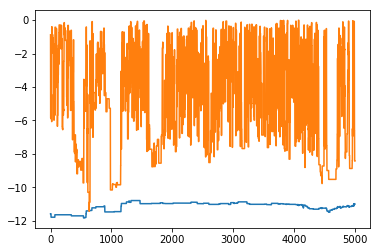

In [28]:
plt.plot(gen_mcmc.trace('DeltaG_L')[:])
plt.plot(gen_mcmc.trace('DeltaG_B')[:])

/Users/choderaj/miniconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/choderaj/miniconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


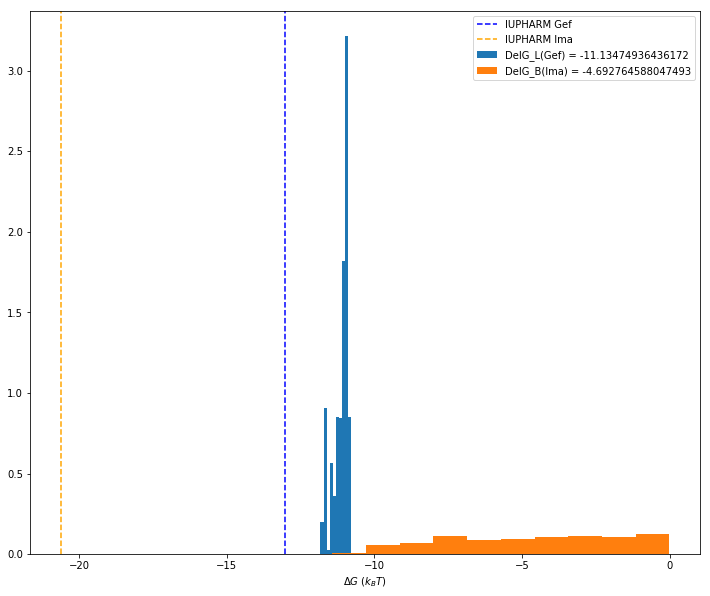

In [29]:
plt.figure(figsize=(12,10))
plt.hist(gen_mcmc.trace('DeltaG_L')[:],normed=True,label='DelG_L(Gef) = %s' %gen_mcmc.trace('DeltaG_L')[:].mean());
plt.axvline(x=AblGef_dG,color='b',linestyle='--',label='IUPHARM Gef')
plt.hist(gen_mcmc.trace('DeltaG_B')[:],normed=True,label='DelG_B(Ima) = %s' %gen_mcmc.trace('DeltaG_B')[:].mean());
plt.axvline(x=AblIma_dG,color='orange',linestyle='--',label='IUPHARM Ima')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.legend(loc=0);

In [ ]:
nburn = 10
nthin = 1
niter = 10
%prun gen_mcmc.sample(iter=(nburn+niter), burn=nburn, thin=nthin, progress_bar=True, tune_throughout=True)

In [ ]:
%load_ext line_profiler
nburn = 10
nthin = 1
niter = 10
%lprun -f bindingmodels.GeneralBindingModel.equilibrium_concentrations gen_mcmc.sample(iter=(nburn+niter), burn=nburn, thin=nthin, progress_bar=True, tune_throughout=True)